<a href="https://colab.research.google.com/github/scottspurlock/csc4466-s2024/blob/main/demos/day24_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision
## Day 24 Object Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os

import torch
import torchvision.transforms as T
import torchvision
import torch

--2024-05-01 22:02:36--  https://images.unsplash.com/photo-1484704324500-528d0ae4dc7d
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2792764 (2.7M) [image/jpeg]
Saving to: ‘birds.jpg’

birds.jpg           100%[===================>]   2.66M  --.-KB/s    in 0.08s   

2024-05-01 22:02:37 (33.6 MB/s) - ‘birds.jpg’ saved [2792764/2792764]



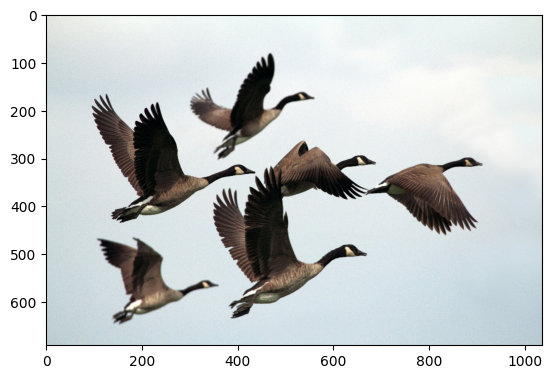

In [2]:
! wget https://images.unsplash.com/photo-1484704324500-528d0ae4dc7d -O birds.jpg

img = cv2.imread('birds.jpg')[:, :, ::-1]

# if the image is big, resizing can make things run faster
img = cv2.resize(img, None, fx=0.2, fy=0.2)
plt.imshow(img)

In [3]:
# get the pretrained model from torchvision.models
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights)

# model.eval() to use the model for inference (no training)
model.eval()

# Coco class labels
# Note that there are some N/A's
COCO_LABELS = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:03<00:00, 47.9MB/s]


## run model on image

In [4]:
# convert image from numpy array to pytorch tensor (and make it channels first)
transform = T.Compose([T.ToTensor()])
x = transform(img.copy())
x.size()

torch.Size([3, 691, 1037])

In [5]:
# pass image through model
pred = model([x])

# pred is a list (one for each input image)
# since there's just one image
pred = pred[0]

# each prediction is a dictionary:
# - boxes: list of boxes (4 coordinates)
# - labels: list of indexes based on COCO label names
# - scores: list of confidence values for the detections
pred

{'boxes': tensor([[104.7235, 462.8229, 361.0485, 648.7895],
         [ 94.9543, 163.2707, 440.8026, 432.8317],
         [300.8205,  78.9553, 561.3292, 304.5709],
         [665.9909, 299.3691, 910.9818, 459.4939],
         [355.1067, 323.2797, 669.3243, 628.0538],
         [464.0272, 266.9401, 689.5528, 388.3954],
         [ 94.1037, 181.4928, 808.3492, 460.0985],
         [334.0238, 283.9473, 911.1071, 620.3492],
         [441.1982, 277.6886, 906.1746, 473.6638],
         [392.9254, 267.3027, 701.5767, 478.9602]], grad_fn=<StackBackward0>),
 'labels': tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
 'scores': tensor([0.9980, 0.9971, 0.9970, 0.9961, 0.9948, 0.9455, 0.1462, 0.1393, 0.0718,
         0.0519], grad_fn=<IndexBackward0>)}

+ keeping confidence 1.00
[104.72353 462.8229  361.04852 648.7895 ]
+ keeping confidence 1.00
[ 94.954254 163.2707   440.80264  432.8317  ]
+ keeping confidence 1.00
[300.82047   78.955284 561.3292   304.5709  ]
+ keeping confidence 1.00
[665.9909  299.36908 910.9818  459.4939 ]
+ keeping confidence 0.99
[355.10672 323.27972 669.3243  628.0538 ]
+ keeping confidence 0.95
[464.02722 266.94006 689.5528  388.39545]
- discarding confidence 0.15
- discarding confidence 0.14
- discarding confidence 0.07
- discarding confidence 0.05


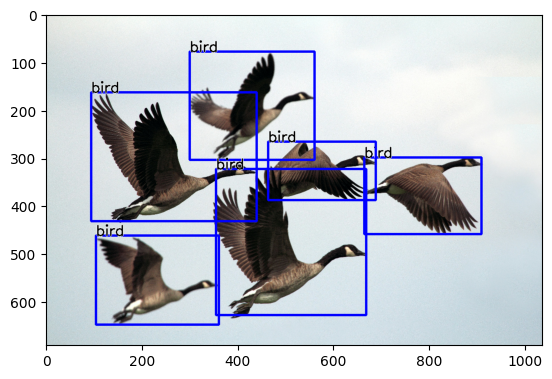

In [6]:
SCORE_THRESH = 0.5

disp = img.copy()
num_detections = len(pred['boxes'])

for i in range(num_detections):
    # score
    score = pred['scores'][i].detach().numpy()
    if score < SCORE_THRESH:
        print(f'- discarding confidence {score:.2f}')
        continue
    else:
        print(f'+ keeping confidence {score:.2f}')

    # bounding box
    box = pred['boxes'][i].detach().numpy()
    print(box)
    top_left = (int(box[0]), int(box[1]))
    bottom_right = (int(box[2]), int(box[3]))
    cv2.rectangle(disp, top_left, bottom_right, color=(0, 0, 255), thickness=4)

    # label
    label_idx = pred['labels'][i].detach().numpy()
    label = COCO_LABELS[label_idx]
    cv2.putText(disp, label, top_left, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[255, 255, 255], thickness=4)
    cv2.putText(disp, label, top_left, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[0, 0, 0], thickness=2)

plt.imshow(disp)

# Mask R-CNN

In [7]:
# get the pretrained model from torchvision.models
weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)

# model.eval() to use the model for inference (no training)
model.eval()


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:02<00:00, 68.7MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [8]:
# convert image from numpy array to pytorch tensor (and make it channels first)
transform = T.Compose([T.ToTensor()])
x = transform(img.copy())

# pass image through model
pred = model([x])

# pred is a list (one for each input image)
# since there's just one image
pred = pred[0]

# each prediction is a dictionary:
# - boxes: list of boxes (4 coordinates)
# - labels: list of indexes based on COCO label names
# - scores: list of confidence values for the detections
pred

{'boxes': tensor([[100.2878, 164.4763, 429.9323, 433.5115],
         [109.0744, 465.9187, 361.7090, 649.5220],
         [302.1771,  78.5263, 562.1400, 305.7641],
         [346.1143, 298.6360, 672.0541, 633.5248],
         [644.1473, 299.0962, 909.9015, 460.6806],
         [446.6196, 267.9654, 690.8195, 386.4341],
         [340.0752, 268.0239, 687.2010, 476.9103],
         [409.7859, 289.1380, 910.6977, 503.9390],
         [196.2567, 187.9478, 671.4661, 407.1085],
         [139.8434, 212.6926, 686.7832, 533.0176]], grad_fn=<StackBackward0>),
 'labels': tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
 'scores': tensor([0.9993, 0.9982, 0.9976, 0.9968, 0.9958, 0.8210, 0.1478, 0.1379, 0.0839,
         0.0739], grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 

In [9]:
# from https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/visualize.py
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 255,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


+ keeping confidence 1.00
bird


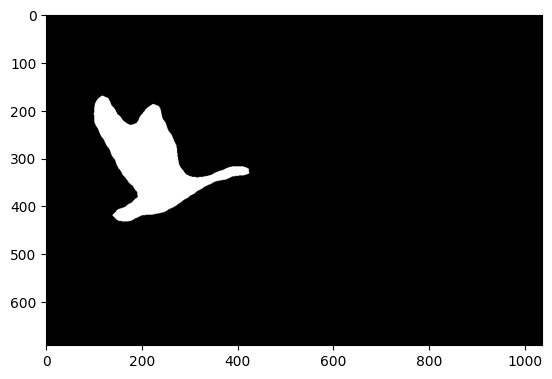

+ keeping confidence 1.00
bird


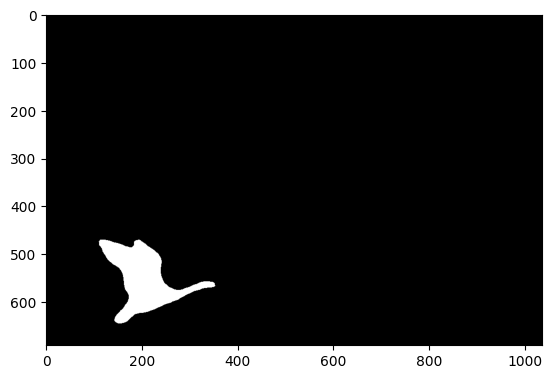

+ keeping confidence 1.00
bird


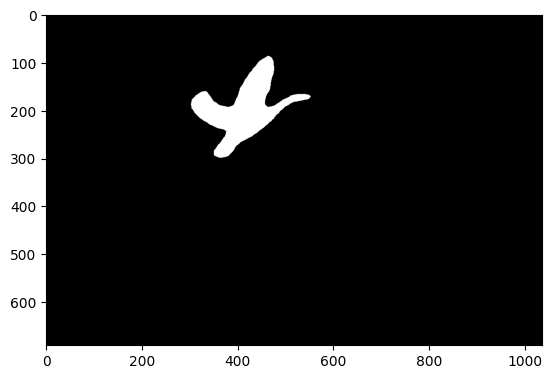

+ keeping confidence 1.00
bird


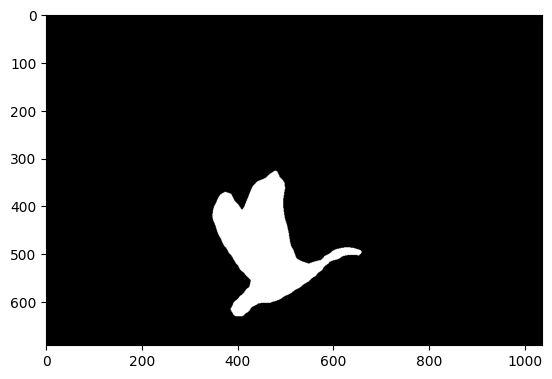

+ keeping confidence 1.00
bird


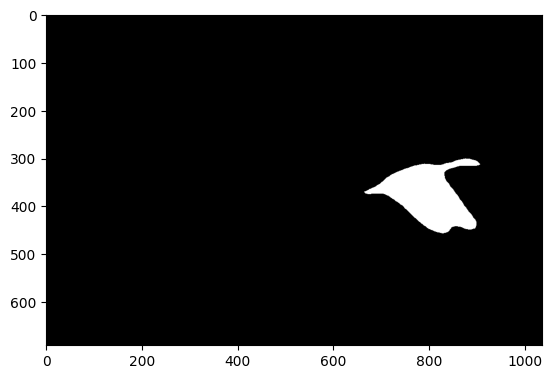

+ keeping confidence 0.82
bird


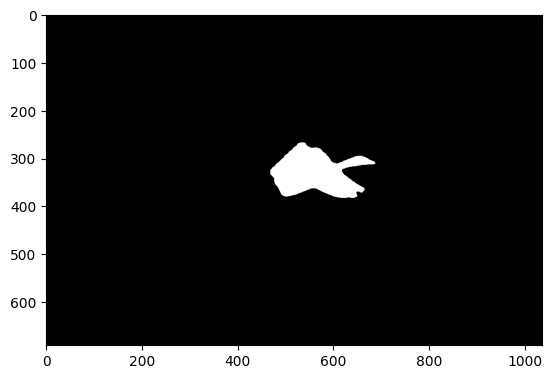

- discarding confidence 0.15
- discarding confidence 0.14
- discarding confidence 0.08
- discarding confidence 0.07


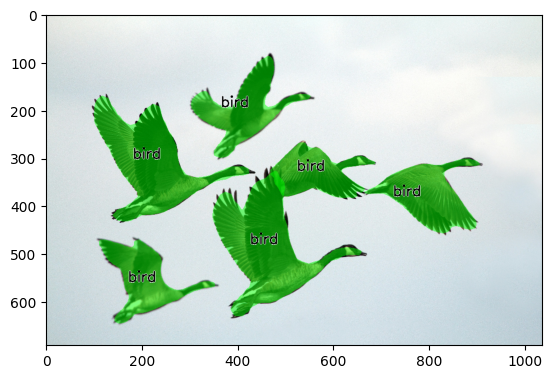

In [10]:
SCORE_THRESH = 0.5

disp = img.copy()
num_detections = len(pred['boxes'])

for i in range(num_detections):
    # score
    score = pred['scores'][i].detach().numpy()
    if score < SCORE_THRESH:
        print(f'- discarding confidence {score:.2f}')
        continue
    else:
        print(f'+ keeping confidence {score:.2f}')

    # label
    label_idx = pred['labels'][i].detach().numpy()
    label = COCO_LABELS[label_idx]
    print(label)

    # mask
    mask = pred['masks'][i].detach().numpy()[0]
    mask[mask >= 0.5] = 255
    mask[mask < 0.5] = 0
    mask = mask.astype('uint8')
    plt.imshow(mask, cmap='gray')
    plt.show()

    # apply mask to image
    # disp = apply_mask(disp, mask, np.random.randint(0, 255, (3, ), dtype='uint8'))
    disp = apply_mask(disp, mask, [0, 1, 0])

    # bounding box around contour
    contours, _ = cv2.findContours(mask.copy(),
            cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])

    # show label
    cv2.putText(disp, label, (x+w//4, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[255, 255, 255], thickness=3)
    cv2.putText(disp, label, (x+w//4, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=[0, 0, 0], thickness=2)

plt.imshow(disp)